<a href="https://colab.research.google.com/github/abrange/mit-deeplearning/blob/main/module_3/Deep_Learning_Mastering_Neural_Networks_Module_3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3 Assignment: MNIST Classification

Now that we have the full power of PyTorch at our disposal, we would like to classify a more concrete dataset. In particular, we are going to look at building a classifier for the [MNIST Handwritten Digits dataset](https://en.wikipedia.org/wiki/MNIST_database). This dataset contains tens of thousands of handwritten digits from 0-9 and is very commonly used for machine learning algorithm development. In this assignment, we will provide some basic dataloading code and would like you to build a deep neural network that is trained on the MNIST dataset! Feel free to reuse code you have written or seen before in previous notebooks!

In [20]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

First we will load in our MNIST dataset. Pytorch provides built in functions for loading popular image datasets, MNIST is one of them.

In [41]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                # Move tensor to CPU before plotting
                plt.plot(epochs, [t.cpu() if isinstance(t, torch.Tensor) else t for t in training_curves[phase+'_'+metric]])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

In [21]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50_000, 10_000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)


In [22]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [31]:
# Hint! In the Module 3 Introduction to Pytorch notebook, the Network
# we created required the input data to be of shape Nx1 where N is the number of
# features. Currently, our MNIST dataset is shape 28x28 as they are images. Use
# this code snippet as you iterate through the datapoint in your dataset to flatten
# them so it is size 784x1 and can be used with the models we designed previously!

# This loop only iterates through the "train" datapoints
# In the previous notebook
phases = ["train", "val", "test"]
for phase in phases:
  count = 0
  for inputs, labels in dataloaders[phase]:
    #print(inputs.shape, labels.shape)
    count += 1

    # This flattens every every batch to the correct size!
    before = inputs.shape
    inputs = inputs.view(inputs.shape[0],-1)
    print("before", before, "after", inputs.shape)
    break

  print("end count", phase, count)

before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count train 1
before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count val 1
before torch.Size([100, 1, 28, 28]) after torch.Size([100, 784])
end count test 1


In [24]:
print(inputs.shape)
print(inputs)

torch.Size([100, 784])
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


In [25]:
# Create 2 models as Python class for a Mulity Category Classifier that inherit from pytorch.nn.Model

# Simple two-hidden-layer classification model
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Simple three-hidden-layer classification model
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [53]:
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FEATURE_LEN = 784
# hyperparameters

# model architecture
input_size = FEATURE_LEN
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 64
num_classes = 10

# external training parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 20

In [48]:
# Print the models
two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)
SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [49]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

## # Two-hidden-Layer Training trainning and error visualization

> Add blockquote




Epoch 1/50
----------
train Loss: 0.5006 Acc: 0.8573
val   Loss: 0.2983 Acc: 0.9120
test  Loss: 0.2845 Acc: 0.9128

Epoch 2/50
----------
train Loss: 0.2651 Acc: 0.9212
val   Loss: 0.2401 Acc: 0.9281
test  Loss: 0.2275 Acc: 0.9276

Epoch 3/50
----------
train Loss: 0.2126 Acc: 0.9363
val   Loss: 0.1979 Acc: 0.9399
test  Loss: 0.1836 Acc: 0.9412

Epoch 4/50
----------
train Loss: 0.1770 Acc: 0.9465
val   Loss: 0.1699 Acc: 0.9485
test  Loss: 0.1543 Acc: 0.9528

Epoch 5/50
----------
train Loss: 0.1520 Acc: 0.9543
val   Loss: 0.1523 Acc: 0.9537
test  Loss: 0.1363 Acc: 0.9593

Epoch 6/50
----------
train Loss: 0.1341 Acc: 0.9596
val   Loss: 0.1423 Acc: 0.9575
test  Loss: 0.1249 Acc: 0.9617

Epoch 7/50
----------
train Loss: 0.1203 Acc: 0.9634
val   Loss: 0.1347 Acc: 0.9606
test  Loss: 0.1178 Acc: 0.9646

Epoch 8/50
----------
train Loss: 0.1091 Acc: 0.9670
val   Loss: 0.1295 Acc: 0.9612
test  Loss: 0.1125 Acc: 0.9662

Epoch 9/50
----------
train Loss: 0.0998 Acc: 0.9698
val   Loss: 0.1245

# 2 hidden-layers models

In [50]:
# Your code here #
# I will try first with a 2 hidden-layers models

model = two_layer_model

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Make sure you save the training curves along the way for visualization afterwards!
two_layer_model, training_curves_two_layer = train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
  )



Epoch 1/15
----------
train Loss: 0.4776 Acc: 0.8611
val   Loss: 0.2736 Acc: 0.9185
test  Loss: 0.2572 Acc: 0.9221

Epoch 2/15
----------
train Loss: 0.2390 Acc: 0.9288
val   Loss: 0.2069 Acc: 0.9396
test  Loss: 0.1970 Acc: 0.9376

Epoch 3/15
----------
train Loss: 0.1762 Acc: 0.9476
val   Loss: 0.1703 Acc: 0.9485
test  Loss: 0.1556 Acc: 0.9503

Epoch 4/15
----------
train Loss: 0.1385 Acc: 0.9580
val   Loss: 0.1457 Acc: 0.9584
test  Loss: 0.1276 Acc: 0.9595

Epoch 5/15
----------
train Loss: 0.1156 Acc: 0.9647
val   Loss: 0.1379 Acc: 0.9598
test  Loss: 0.1200 Acc: 0.9625

Epoch 6/15
----------
train Loss: 0.0998 Acc: 0.9694
val   Loss: 0.1317 Acc: 0.9604
test  Loss: 0.1126 Acc: 0.9641

Epoch 7/15
----------
train Loss: 0.0874 Acc: 0.9735
val   Loss: 0.1287 Acc: 0.9627
test  Loss: 0.1083 Acc: 0.9657

Epoch 8/15
----------
train Loss: 0.0776 Acc: 0.9771
val   Loss: 0.1271 Acc: 0.9623
test  Loss: 0.1082 Acc: 0.9670

Epoch 9/15
----------
train Loss: 0.0695 Acc: 0.9789
val   Loss: 0.1236

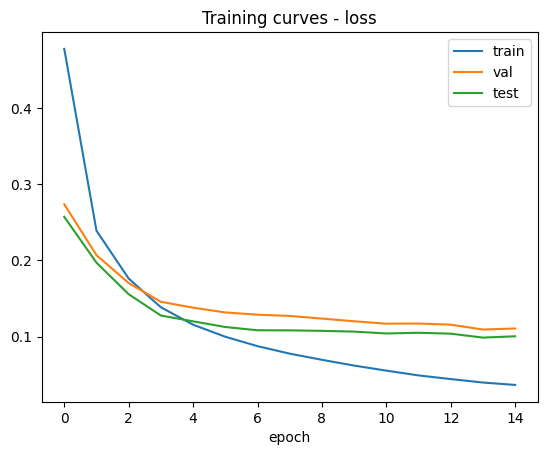

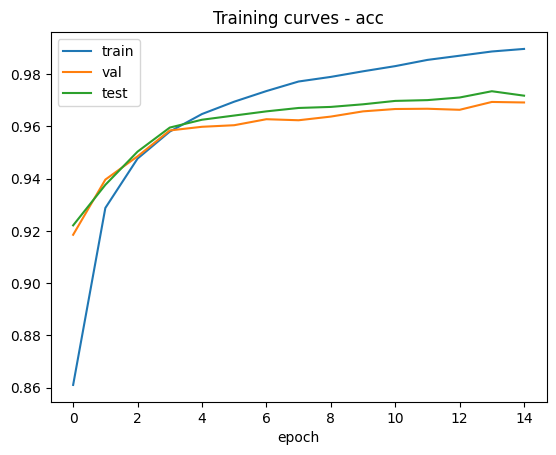

In [51]:
plot_training_curves(training_curves_two_layer, phases=['train', 'val', 'test'])

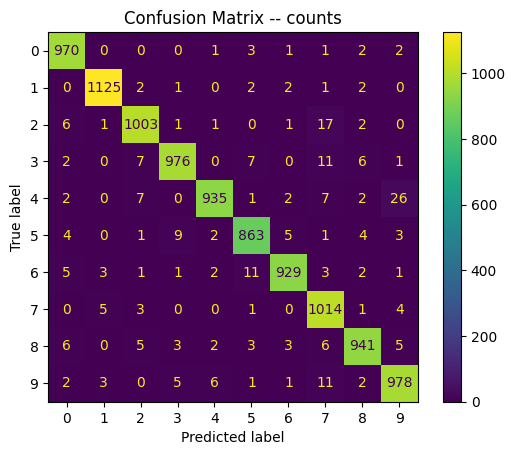

In [52]:
res = plot_cm(two_layer_model, device, dataloaders, phase='test')

## 3 Layers

In [ ]:
# Your code here #
# I will try first with a 2 hidden-layers models

model = three_layer_model

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Make sure you save the training curves along the way for visualization afterwards!
three_layer_model, training_curves_three_layer = train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs
  )


Epoch 1/20
----------
train Loss: 2.3035 Acc: 0.1040
val   Loss: 2.3034 Acc: 0.1085
test  Loss: 2.3032 Acc: 0.1138

Epoch 2/20
----------
train Loss: 2.3035 Acc: 0.1040


In [ ]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

In [ ]:
res = plot_cm(three_layer_model, device, dataloaders, phase='test')